In [1]:
%matplotlib inline
import numpy as np
from numpy import pi

from scipy import signal
from scipy import sparse
from scipy import special
from scipy.optimize import *
from scipy.stats import vonmises

from sklearn.datasets import make_sparse_spd_matrix

import matplotlib.pyplot as plt

import time
import scipy.io

In [2]:
def VonMises2(x,k1,k2,m1,m2,A):
    """
    Unnormalized generalized von mises function of order 2
    k1 and k2 are the concentration parameters
    m1 and m2 are the means of the first and second harmonics
    A is the amplitude
    """
    return A*np.exp(k1*np.cos(x - m1) + k2*np.cos(2*(x - m2)))

def VonMises2_nat(x,a,b,a2,b2):
    """
    Unnormalized generalized von mises function of order 2
    with natural parameters
    """
    return np.exp(a*np.cos(x) + b*np.sin(x) + a2*np.cos(2*x) + b2*np.sin(2*x))

def generateCouplings(Nx,sp,K):
    """
    Generate a Nx x Nx x 4 tensor of couplings. 
    Each coupling is characterized by 4 parameters: cosine-cosine, cosine-sine, s-c and s-s interactions
    Nx: No. of variables
    sp: sparsity, i.e, fraction of zero entries in adjacency matrix
    K: scaling factor
    """
    AdjMat = (np.tril(np.random.rand(Nx,Nx) > sp,-1))*1.0
    AdjMat = AdjMat + AdjMat.T

    # then generate the coupling matrices: Jcc, Jcs, Jsc, Jss
    J = np.zeros([Nx,Nx,4])
    
    Jcc = np.tril(np.random.randn(Nx,Nx),-1)
    Jss = np.tril(np.random.randn(Nx,Nx),-1)
    Jcs = np.tril(np.random.randn(Nx,Nx),-1)
    Jsc = np.tril(np.random.randn(Nx,Nx),-1)
    
    J[:,:,0] = Jcc + Jcc.T
    J[:,:,1] = Jcs + Jsc.T
    J[:,:,2] = Jsc + Jcs.T
    J[:,:,3] = Jss + Jss.T
    
    J = K*J*np.expand_dims(AdjMat,2)
    return J
    

def generateVonMisesCouplings(J, MuVec, M):
    """
    Compute the parameters of the interaction function for each edge, in both directions ij and ji
    """    
    x = np.linspace(-pi,pi,M) # we can reduce the number of sample here if necessary
    N = J.shape[0]
    Ja = np.zeros([N,N,M])
    Jb = np.zeros([N,N,M])
    
    AdjMat = (J[:,:,0] != 0)*1 #adjacency matrix
    
    for ii in range(N):
        for jj in range(N):
            if AdjMat[ii,jj] != 0:
                Jcc = J[ii,jj,0]
                Jcs = J[ii,jj,1]
                Jsc = J[ii,jj,2]
                Jss = J[ii,jj,3]

                cj = np.cos(x - MuVec[jj])
                sj = np.sin(x - MuVec[jj])

                ci = np.cos(MuVec[ii])
                si = np.sin(MuVec[ii])

                Ja[ii,jj,:] = Jcc*ci*cj + Jcs*ci*sj - Jsc*si*cj - Jss*si*sj
                Jb[ii,jj,:] = Jcc*si*cj + Jcs*si*sj + Jsc*ci*cj + Jss*ci*sj
                
    return Ja, Jb


In [3]:
def VMBP(KVec, MuVec, J, lam, T):
    """
    Function that implements belief propagation for a pairwise Von Mises graphical model
    using curve fitting
    Inputs:
        KVec:  concentration parameters
        MuVec: preferred orientations
        J:     interaction matrix
        lam:   relaxation for updates, between 0 and 1
        T:     number of interations to run BP for

    Outputs: 
        AVec:  vector of marginal cosine natural parameters
        BVec:  vector of marginal sine natural parameters
        A2Vec: vector of marginal cosine2 natural parameters
        B2Vec: vector of marginal sine2 natural parameters
        AMat:  time series of marginal cosine natural parameters
        BMat:  time series of marginal sine natural parameters
        A2Mat: time series of marginal cosine2 natural parameters
        B2Mat: time series of marginal sine2 natural parameters
    """


    # Curve fitting parameters
    init_vals = [1,0.5,-0.1,0.1,5] 
    lb = [0,0,-pi,-pi/2,0]
    ub = [10,10,pi,pi/2,100]

    # Parameters of the singleton potentials
    # Convert the concentration and means to the natural parameters
    A0Vec = KVec*np.cos(MuVec)
    B0Vec = KVec*np.sin(MuVec)

    # Parameters of the pairwise potentials
    M = 30
    Ja, Jb = generateVonMisesCouplings(J, MuVec, M)

    AdjMat = (J[:,:,0] != 0)*1 #adjacency matrix

    # Initialize the parameters of the messages
    # MA[i,j] corresponds to cosine parameter of the message sent from node i to node j
    # MB[i,j] corresponds to sine parameter of the message sent from node i to node j
    # MA2[i,j] corresponds to cosine2 parameter of the message sent from node i to node j
    # MB2[i,j] corresponds to sine2 parameter of the message sent from node i to node j

    MA    = np.zeros([N,N])
    MB    = np.zeros([N,N])
    MA2   = np.zeros([N,N])
    MB2   = np.zeros([N,N])

    MAnew    = np.zeros([N,N])
    MBnew    = np.zeros([N,N])
    MA2new   = np.zeros([N,N])
    MB2new   = np.zeros([N,N])

    # Initialize the parameters of the beliefs
    AVec = np.zeros([N])
    BVec = np.zeros([N])
    A2Vec = np.zeros([N])
    B2Vec = np.zeros([N])

    AMat = np.zeros([N,T+1])
    BMat = np.zeros([N,T+1])
    A2Mat = np.zeros([N,T+1])
    B2Mat = np.zeros([N,T+1])

    AMat[:,0] = A0Vec
    BMat[:,0] = B0Vec


    for t in range(T):
        for i in range(N):
            for j in range(N):
                if AdjMat[i,j]:
                    # update parameters of message from i -> j

                    # 1. Multiply singleton factor and all the incoming messages to i, expect j->i
                    alpha = A0Vec[i] + np.sum(MA[:,i]) - MA[j,i]
                    beta  = B0Vec[i] + np.sum(MB[:,i]) - MB[j,i]
                    alpha2 = np.sum(MA2[:,i]) - MA2[j,i]
                    beta2  = np.sum(MB2[:,i]) - MB2[j,i]

                    #2. Multiply the interaction terms
                    alpha = alpha + Ja[i,j,:]
                    beta  = beta + Jb[i,j,:]

                    #3. Compute the bessel function approximation to the marginal for the message
                    K1 = np.sqrt(alpha**2 + beta**2)
                    # Mu1 = np.arctan2(alpha,beta)
                    Mu1 = np.arctan2(beta,alpha)
                    K2 = np.sqrt(alpha2**2 + beta2**2)
                    Mu2 = 0.5*np.arctan2(beta2,alpha2)
                    dMu = np.mod(Mu1 - Mu2,pi)

                    G0 = special.iv(0,K1)*special.iv(0,K2)
                    # Include first 2 terms from this infinite series approximation for G0
                    for n in range(1,3):
                        G0 = G0 + 2*special.iv(2*n,K1)*special.iv(n,K2)*np.cos(2*n*dMu)

                    # Message = 2*pi*np.prod(Gam[:,i])*G0/Gam[j,i] 
                    Message = 2*pi*G0

                    # 4. Do curve fitting to update the message parameters
                    x = np.linspace(-pi,pi,M)
                    bv = curve_fit(VonMises2, x, Message, p0=init_vals, bounds=(lb,ub))[0]

                    # Update the parameters
                    MAnew[i,j] = (1-lam)*MA[i,j] + lam*bv[0]*np.cos(bv[2])
                    MBnew[i,j] = (1-lam)*MB[i,j] + lam*bv[0]*np.sin(bv[2])
                    MA2new[i,j] = (1-lam)*MA2[i,j] + lam*bv[1]*np.cos(2*bv[3])
                    MB2new[i,j] = (1-lam)*MB2[i,j] + lam*bv[1]*np.sin(2*bv[3])

        # Compute the beliefs
        AVec = A0Vec + np.sum(MAnew,axis=0)
        BVec = B0Vec + np.sum(MBnew,axis=0)
        A2Vec = np.sum(MA2new,axis=0)
        B2Vec = np.sum(MB2new,axis=0)

        AMat[:,t+1] = AVec*1.0
        BMat[:,t+1] = BVec*1.0
        A2Mat[:,t+1] = A2Vec*1.0
        B2Mat[:,t+1] = B2Vec*1.0

        MA = MAnew*1.0
        MB = MBnew*1.0
        MA2 = MA2new*1.0
        MB2 = MB2new*1.0
    
    return AMat[:,1:], BMat[:,1:], A2Mat[:,1:], B2Mat[:,1:]



In [4]:
# Script begins here

N = 9 # No. of variables

# Singleton factor parameters
KVec = 1*np.random.rand(N) #concentration vector
MuVec = np.random.rand(N)*2*pi - pi #preferred orientations

# Pairwise factor parameters
sp = 0.6 #fraction of zero entries
GJ = 0.9 #global coupling strength
J = generateCouplings(N,sp,GJ)

# # rounding -- this is not necessary
# KVec = np.round(100*KVec)/100
# MuVec = np.round(100*MuVec)/100
# J = np.round(100*J)/100

AdjMat = (J[:,:,0] != 0)*1 #adjacency matrix

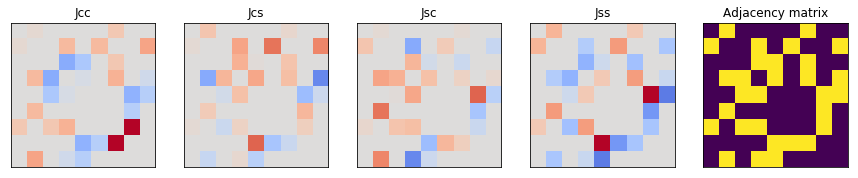

In [5]:
# Plotting the couplings
fig, ax = plt.subplots(1,5,figsize=(15,4))
vl = -2*GJ
vu = 2*GJ
ax[0].imshow(J[:,:,0],cmap='coolwarm',vmin=vl,vmax=vu)
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[0].set_title('Jcc')
ax[1].imshow(J[:,:,1],cmap='coolwarm',vmin=vl,vmax=vu)
ax[1].set_xticks([]); ax[1].set_yticks([])
ax[1].set_title('Jcs')
ax[2].imshow(J[:,:,2],cmap='coolwarm',vmin=vl,vmax=vu)
ax[2].set_xticks([]); ax[2].set_yticks([])
ax[2].set_title('Jsc')
ax[3].imshow(J[:,:,3],cmap='coolwarm',vmin=vl,vmax=vu)
ax[3].set_xticks([]); ax[3].set_yticks([])
ax[3].set_title('Jss')
ax[4].imshow(AdjMat)
ax[4].set_xticks([]); ax[4].set_yticks([])
ax[4].set_title('Adjacency matrix')
plt.show()

In [6]:
# Run the inference algorithm
t_st = time.time()
AMat, BMat, A2Mat, B2Mat = VMBP(KVec,MuVec,J,lam=0.5,T=25)
t_en = time.time()
print('Time taken = ',t_en-t_st)

Time taken =  4.2742369174957275


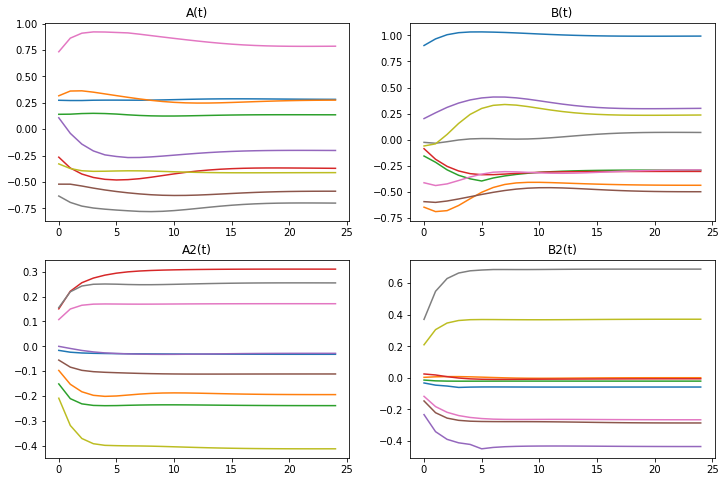

In [7]:
# Plotting the dynamics of the marginal paramaters
fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(AMat.T)
ax[0,0].set_title('A(t)')
ax[0,1].plot(BMat.T)
ax[0,1].set_title('B(t)')
ax[1,0].plot(A2Mat.T)
ax[1,0].set_title('A2(t)')
ax[1,1].plot(B2Mat.T)
ax[1,1].set_title('B2(t)')
plt.show()

In [8]:
# Compute the marginals
x = np.linspace(-pi,pi,200)
dx = x[1] - x[0]

pMat = np.zeros([len(x),N])
for n in range(N):
    y = VonMises2_nat(x,AMat[n,-1],BMat[n,-1],A2Mat[n,-1],B2Mat[n,-1])
    y = y/(sum(y)*dx)
    pMat[:,n] = y
    
ffMat = np.zeros([len(x),N])
for n in range(N):
    y = np.exp(KVec[n]*np.cos(x - MuVec[n]))/(2*pi*special.iv(0,KVec[n]))
    ffMat[:,n] = y
    
# plt.plot(x,pMat)
# plt.xlabel('x')
# plt.ylabel('p_i(x)')
# plt.title('Marginal pdfs')
# plt.axis([-pi,pi,0,np.ceil(10*np.max(pMat))/10])
# plt.show()

Red: local evidence, Blue: marginals


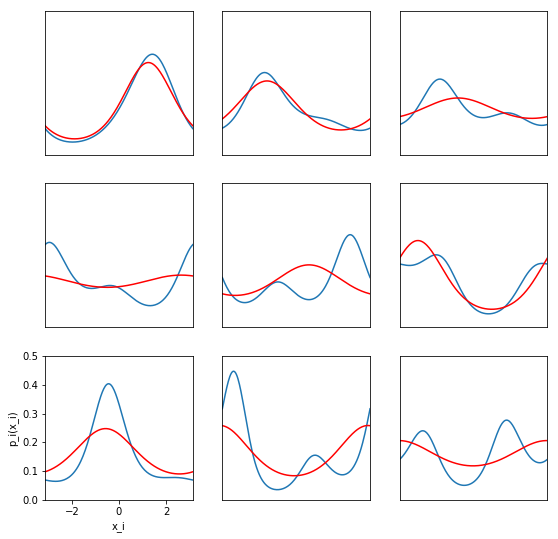

In [9]:
fig, ax = plt.subplots(3,3,figsize=(9,9))
ax = ax.ravel()
for i in range(9):
    ax[i].plot(x,pMat[:,i])
    ax[i].plot(x,ffMat[:,i],'r')
    ax[i].axis([-pi,pi,0,np.ceil(10*np.max(pMat))/10])
    if i != 6:
        ax[i].set_xticks([]); ax[i].set_yticks([])
    else:
        ax[i].set_xlabel('x_i')
        ax[i].set_ylabel('p_i(x_i)')
        
        
print('Red: local evidence, Blue: marginals')

In [14]:
# mdict={'AdjMat':AdjMat}
# scipy.io.savemat('AdjMat.mat', mdict)
# mdict={'J':J}
# scipy.io.savemat('J.mat', mdict)

In [10]:
# fig, ax = plt.subplots(10,20,figsize=(25,15))
# ax = ax.ravel()
# for i in range(200):
#     ax[i].plot(x,pMat[:,i])
#     ax[i].axis([-pi,pi,0,np.ceil(10*np.max(pMat))/10])
#     if i != 180:
#         ax[i].set_xticks([]); ax[i].set_yticks([])
#     else:
#         ax[i].set_xlabel('x_i')
#         ax[i].set_ylabel('p_i(x_i)')